# Coursework 2: Fish Classification

Created by Athanasios Vlontzos and Wenjia Bai

In this coursework, you will be exploring the application of convolutional neural networks for image classification tasks. As opposed to standard applications such as object or face classification, we will be dealing with a slightly different domain, fish classification for precision fishing.

In precision fishing, engineers and fishmen collaborate to extract a wide variety of information about the fish, their species and wellbeing etc. using data from satellite images to drones surveying the fisheries. The goal of precision fishing is to provide the marine industry with information to support their decision making processes.

Here your will develop an image classification model that can classify fish species given input images. It consists of two tasks. The first task is to train a model for the following species:
- Black Sea Sprat
- Gilt-Head Bream
- Shrimp
- Striped Red Mullet
- Trout

The second task is to finetune the last layer of the trained model to adapt to some new species, including:
- Hourse Mackerel
- Red Mullet
- Red Sea Bream
- Sea Bass

You will be working using a large-scale fish dataset [1].

[1] O. Ulucan, D. Karakaya and M. Turkan. A large-scale dataset for fish segmentation and classification. Innovations in Intelligent Systems and Applications Conference (ASYU). 2020.

## Step 0: Download data.

[Download the Data from here -- make sure you access it with your Imperial account.](https://imperiallondon-my.sharepoint.com/:f:/g/personal/av2514_ic_ac_uk/EkA9HyXVvgdFoLI4P_IfO1cBO_CsvY1KN4NE8iuD-s_VlA?e=Ip03rF)

It is a ~2.5GB file. You can save the images and annotations directories in the same directory as this notebook or somewhere else.

The fish dataset contains 9 species of fishes. There are 1,000 images for each fish species, named as %05d.png in each subdirectory.

## Step 1: Load the data. (15 Points)

- Complete the dataset class with the skeleton below.
- Add any transforms you feel are necessary.

Your class should have at least 3 elements
- An ```__init__``` function that sets up your class and all the necessary parameters.
- An ```__len__``` function that returns the size of your dataset.
- An ```__getitem__``` function that given an index within the limits of the size of the dataset returns the associated image and label in tensor form.

You may add more helper functions if you want.

In this section we are following the Pytorch [dataset](https://pytorch.org/vision/stable/datasets.html) class structure. You can take inspiration from their documentation.

In [1]:
# Dependencies
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image, ImageFile
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import glob
import pickle

In [2]:
# We will start by building a dataset class using the following 5 species of fishes
Multiclass_labels_correspondances = {
    'Black Sea Sprat': 0,
    'Gilt-Head Bream': 1,
    'Shrimp': 2,
    'Striped Red Mullet': 3,
    'Trout': 4
}

# The 5 species will contain 5,000 images in total.
# Let us split the 5,000 images into training (80%) and test (20%) sets
def split_train_test(lendata, percentage=0.8):
    #### ADD YOUR CODE HERE ####
    indexes = np.array(range(0,lendata))
    np.random.shuffle(indexes)
    train_size = int(lendata * percentage)
    
    idxs_train = indexes[:train_size]
    idxs_test = indexes[train_size:]

    return idxs_train, idxs_test

LENDATA = 5000
np.random.seed(42)
idxs_train, idxs_test = split_train_test(LENDATA,0.8)

In [3]:
# Implement the dataset class
class FishDataset(Dataset):
    def __init__(self,
                 path_to_images,
                 idxs_train,
                 idxs_test,
                 transform_extra=None,
                 img_size=128,
                 train=True):
        # path_to_images: where you put the fish dataset
        # idxs_train: training set indexes
        # idxs_test: test set indexes
        # transform_extra: extra data transform
        # img_size: resize all images to a standard size
        # train: return training set or test set
        
        # Load all the images and their labels
        #### ADD YOUR CODE HERE ####
        inverted_labels = {v: k for k, v in Multiclass_labels_correspondances.items()} # invert the values and keys
        self.filenames_all = []
        self.file_labels = []
        for value in inverted_labels:
            self.filenames_all.extend(glob.glob(path_to_images + "/" + inverted_labels[value] + "/*.png"))
            for i in range(len(glob.glob(path_to_images + "/" + inverted_labels[value] + "/*.png"))):
                self.file_labels.append(value)
        
        # Resize all images to a standard size
        #### ADD YOUR CODE HERE ####
        resize = transforms.Compose([transforms.Resize((img_size,img_size))]) # rezize image before storing in array
    
        self._set = []
        self._labels = []
        if train:
            self._idxs = idxs_train
        else:
            self._idxs = idxs_test
        
        self.transform = transforms.ToTensor()
        for index in self._idxs:
            # train_set contains list of tensors
            img = resize(Image.open(self.filenames_all[index]))
            img_tensor = self.transform(img)
            self._set.append(img_tensor)
            # train labels contains list of labels
            self._labels.append(self.file_labels[index])
        # stack the images into a 4D tensor
        self.train_set = torch.stack(self._set)
#         for index in idxs_test:
#             # test_set contains list of tensors
#             img = resize(Image.open(self.filenames_all[index]))
#             img_tensor = img_tensor = self.transform(img)
#             self.test_set.append(img_tensor)
#             # test labels contains list of labels
#             self.test_labels.append(self.file_labels[index])
#         # stack the images into a 4D tensor
#         self.test_set = torch.stack(self.test_set)
           
        # Extract the images and labels with the specified file indexes      
        #### ADD YOUR CODE HERE ####
        
    def __len__(self):
        # Return the number of samples
        #### ADD YOUR CODE HERE ####
        return self._idxs.size
        
    def __getitem__(self, idx):
        # Get an item using its index
        '''
        Returns (image,label)
        '''
        #### ADD YOUR CODE HERE ####
        return (self._set[idx], self._labels[idx])

## Step 2: Explore the data. (15 Points)

### Step 2.1: Data visualisation. (5 points)

- Plot data distribution, i.e. the number of samples per class.
- Plot 1 sample from each of the five classes in the training set.

In [4]:
# Training set
img_path = './Fish_Dataset' # changed to path on my local machine
dataset  = FishDataset(img_path, idxs_train, idxs_test, None, img_size=128, train=True)

In [5]:
test_set = FishDataset(img_path, idxs_train, idxs_test, None, img_size=128, train=False)

Train set:
Number of 'Black Sea Sprat' samples
811
Number of 'Gilt-Head Bream' samples
809
Number of 'Shrimp' samples
787
Number of 'Striped Red Mullet' samples
796
Number of 'Trout' samples
797

Test set:
Number of 'Black Sea Sprat' samples
189
Number of 'Gilt-Head Bream' samples
191
Number of 'Shrimp' samples
213
Number of 'Striped Red Mullet' samples
204
Number of 'Trout' samples
203


Text(0.5, 1.0, 'Distribution of classes in test set')

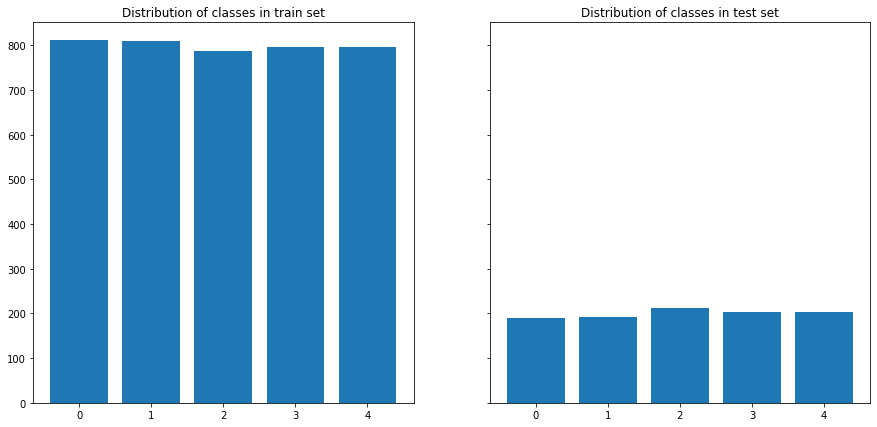

In [6]:
def get_number_of_samples(data, cls):
    return data.count(cls)

# Plot the number of samples per class
#### ADD YOUR CODE HERE ####
print("Train set:")
print("Number of 'Black Sea Sprat' samples")
print(get_number_of_samples(dataset._labels, 0))
print("Number of 'Gilt-Head Bream' samples")
print(get_number_of_samples(dataset._labels, 1))
print("Number of 'Shrimp' samples")
print(get_number_of_samples(dataset._labels, 2))
print("Number of 'Striped Red Mullet' samples")
print(get_number_of_samples(dataset._labels, 3))
print("Number of 'Trout' samples")
print(get_number_of_samples(dataset._labels, 4))

print("\nTest set:")
print("Number of 'Black Sea Sprat' samples")
print(get_number_of_samples(test_set._labels, 0))
print("Number of 'Gilt-Head Bream' samples")
print(get_number_of_samples(test_set._labels, 1))
print("Number of 'Shrimp' samples")
print(get_number_of_samples(test_set._labels, 2))
print("Number of 'Striped Red Mullet' samples")
print(get_number_of_samples(test_set._labels, 3))
print("Number of 'Trout' samples")
print(get_number_of_samples(test_set._labels, 4))

classes = np.array([0,1,2,3,4])
train_distribution = []
for i in range(5):
    train_distribution.append(get_number_of_samples(dataset._labels, i))
train_distribution = np.array(train_distribution)
test_distribution = []
for i in range(5):
    test_distribution.append(get_number_of_samples(test_set._labels, i))
test_distribution = np.array(test_distribution)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,7))
ax1.bar(classes, train_distribution)
ax1.set_title("Distribution of classes in train set")
ax2.bar(classes, test_distribution)
ax2.set_title("Distribution of classes in test set")

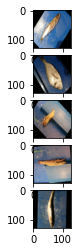

In [7]:
# Plot 1 sample from each of the five classes in the training set
#### ADD YOUR CODE HERE ####
image_sprat = dataset.__getitem__(4)
image_bream = dataset.__getitem__(0)
image_shrimp = dataset.__getitem__(2)
image_mullet = dataset.__getitem__(1)
image_trout = dataset.__getitem__(12)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5)
fig.suptitle('')
ax1.imshow(image_sprat[0].permute(1, 2, 0))
ax2.imshow(image_bream[0].permute(1, 2, 0))
ax3.imshow(image_shrimp[0].permute(1, 2, 0))
ax4.imshow(image_mullet[0].permute(1, 2, 0))
ax5.imshow(image_trout[0].permute(1, 2, 0))

In [8]:
def save_file(filename, data):
    '''
    pickles data into a file
    '''
    pickle.dump(data, open(filename, 'wb'))

train_filename = 'train_data.sav'
save_file(train_filename, dataset)

test_filename = 'test_data.sav'
save_file(test_filename, test_set)

### Step 2.2: Discussion. (10 points)

* Is the dataset balanced?

* Can you think of 3 ways to make the dataset balanced if it is not?

* Is the dataset already pre-processed? If yes, how?

#### ADD YOUR RESPONSE HERE ####
- As you can see from the distribution in part 2.1, there is an uneven distribution of each class within the train and test sets. The numbers are close (within the range 787-811 between min and max), so it is relatively well distributed, but not perfectly distributed. If it was a perfectly balanced dataset, we would see exactly 800 of each in the train set, and 200 of each in the test set.
- Three possible ways to  make the dataset balanced are:
    - Use a larger dataset. If we have more than 5000 data points, the split into train and test is more likely to result in a more even distribution. For example, if we split 50,000 data points, the average will lie much closer to 8,000. 
    - Split the individual classes before combining them. For example, we can split all 1000 trout pictures into 800 train and 200 test, before combining the 5 train classes and 5 test classes. This way, we are guaranteed an exactly perfect distribution of each class in the train and test set. This method would work better for smaller sample sizes such as ours.
    - Another simple solution is to use scikit-learn's _train_test_split_ function, which should automatically divide them into an even distribution.
- The dataset is now pre-processed, because we have made every data point the same size image (128x128x3). I have also chosen to return them as tensors in \_\_getitem\_\_().

## Step 3: Multiclass classification. (55 points)
In this section we will try to make a multiclass classifier to determine the species of the fish.

### Step 3.1: Define the model. (15 points)

Design a neural network which consists of a number of convolutional layers and a few fully connected ones at the end.

The exact architecture is up to you but you do NOT need to create something complicated. For example, you could design a LeNet insprired network.

In [41]:
dataset = pickle.load(open("train_data.sav", "rb"))
test_set = pickle.load(open("test_data.sav", "rb"))

In [8]:
class Net(nn.Module):
    def __init__(self, output_dims = 1):
        super(Net, self).__init__()
        #### ADD YOUR CODE HERE ####
        '''
        Structure: 
          input   -- C1 feature maps -- S2 fmaps  -- C3 fmaps -- S4 fmaps -- 
        128x128x3 --   124x124x6   -- 62x62x6 -- ?x?x3x?  -- ?x?x3x?  -- 
               5x5 conv            pooling      5x5 conv    pooling     
        '''
        self.conv1 = nn.Conv2d(3,6,5)  # output: 124x124x6
        self.relu1 = nn.ReLU()         # activation function
        self.pool1 = nn.MaxPool2d(2)   # 2 stride: 62x62x6
        self.conv2 = nn.Conv2d(6,16,5) # output: 58x58x16
        self.relu2 = nn.ReLU()         # activation function
        self.pool2 = nn.MaxPool2d(2)   # pool : 29x29x16
        self.fc1 = nn.Linear(13456,120)  # fully connected
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120,84) # fully connected
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84,output_dims) # last output has output_dims 
        self.relu5 = nn.ReLU()
        
    def forward(self, x):
        # Forward propagation
        #### ADD YOUR CODE HERE ####
        h = self.conv1(x)
        h = self.relu1(h)
        h = self.pool1(h)
        h = self.conv2(h)
        h = self.relu2(h)
        h = self.pool2(h)
        h = h.view(h.shape[0], -1) # to get [batch_size, num_features]
        h = self.fc1(h)
        h = self.relu3(h)
        h = self.fc2(h)
        h = self.relu4(h)
        h = self.fc3(h)
        y = self.relu5(h)
        return y

# Since most of you use laptops, you may use CPU for training.
# If you have a good GPU, you can set this to 'gpu'.
device = 'cpu'

### Step 3.2: Define the training parameters. (10 points)

- Loss function
- Optimizer
- Learning Rate
- Number of iterations
- Batch Size
- Other relevant hyperparameters

In [42]:
# Network
model = Net(5).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimiser and learning rate
lr = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# Number of iterations for training
epochs = 15

# Training batch size
train_batch_size = 16

# Based on the FishDataset, use the PyTorch DataLoader to load the data during model training
train_dataset = dataset
train_dataloader = DataLoader(train_dataset, batch_size = train_batch_size)
test_dataset = test_set
test_dataloader = DataLoader(test_dataset, batch_size = 1000)

### Step 3.3: Train the model. (15 points)

Complete the training loop.

In [43]:
### Visualizing the shapes and sizes of the dataset ###
print(dataset.__getitem__(0)[0].shape)
print(dataset.__len__())

torch.Size([3, 128, 128])
4000


In [11]:
for epoch in tqdm(range(epochs)):
    model.train()
    loss_curve = []
    
    for images, labels in train_dataloader:
        # Get a batch of training data and train the model
        #### ADD YOUR CODE HERE ####
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        loss_curve += [loss.item()]
    print('--- Iteration {0}: training loss = {1:.4f} ---'.format(epoch + 1, np.array(loss_curve).mean()))

  7%|█████▌                                                                             | 1/15 [00:17<04:00, 17.21s/it]

--- Iteration 1: training loss = 1.6045 ---


 13%|███████████                                                                        | 2/15 [00:34<03:47, 17.47s/it]

--- Iteration 2: training loss = 1.5107 ---


 20%|████████████████▌                                                                  | 3/15 [00:53<03:38, 18.20s/it]

--- Iteration 3: training loss = 1.0750 ---


 27%|██████████████████████▏                                                            | 4/15 [01:13<03:23, 18.54s/it]

--- Iteration 4: training loss = 0.8807 ---


 33%|███████████████████████████▋                                                       | 5/15 [01:31<03:06, 18.67s/it]

--- Iteration 5: training loss = 0.6506 ---


 40%|█████████████████████████████████▏                                                 | 6/15 [01:50<02:48, 18.75s/it]

--- Iteration 6: training loss = 0.4591 ---


 47%|██████████████████████████████████████▋                                            | 7/15 [02:09<02:31, 18.89s/it]

--- Iteration 7: training loss = 0.3101 ---


 53%|████████████████████████████████████████████▎                                      | 8/15 [02:28<02:12, 18.89s/it]

--- Iteration 8: training loss = 0.2220 ---


 60%|█████████████████████████████████████████████████▊                                 | 9/15 [02:47<01:53, 18.89s/it]

--- Iteration 9: training loss = 0.1979 ---


 67%|██████████████████████████████████████████████████████▋                           | 10/15 [03:06<01:34, 18.85s/it]

--- Iteration 10: training loss = 0.1802 ---


 73%|████████████████████████████████████████████████████████████▏                     | 11/15 [03:25<01:15, 18.86s/it]

--- Iteration 11: training loss = 0.1795 ---


 80%|█████████████████████████████████████████████████████████████████▌                | 12/15 [03:44<00:56, 18.86s/it]

--- Iteration 12: training loss = 0.0983 ---


 87%|███████████████████████████████████████████████████████████████████████           | 13/15 [04:03<00:37, 18.88s/it]

--- Iteration 13: training loss = 0.0777 ---


 93%|████████████████████████████████████████████████████████████████████████████▌     | 14/15 [04:22<00:18, 18.93s/it]

--- Iteration 14: training loss = 0.0714 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [04:41<00:00, 18.75s/it]

--- Iteration 15: training loss = 0.0445 ---


### Step 3.4: Deploy the trained model onto the test set. (10 points)

In [12]:
model_save_path = './model_train2.pth'
torch.save(model, model_save_path)

C:\Users\Kaixuan Khoo\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\serialization.py:359: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


In [44]:
model_save_path = './model_train2.pth'
model = torch.load(model_save_path)
model.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=13456, out_features=120, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (relu4): ReLU()
  (fc3): Linear(in_features=84, out_features=5, bias=True)
  (relu5): ReLU()
)

In [45]:
# Deploy the model
#### ADD YOUR CODE HERE ####
## code is combined with accuracy below
correct = 0
total = 0
# modifying these variables for later
predicted = 0 
images, labels = 0, 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 1000 test images: {100. * correct // total} %')

Accuracy of the network on the 1000 test images: 96.0 %


### Step 3.5: Evaluate the performance of the model and visualize the confusion matrix. (5 points)

You can use sklearns related function.

In [15]:
from sklearn.metrics import confusion_matrix

In [16]:
#### ADD YOUR CODE HERE ####
classes = {v: k for k, v in Multiclass_labels_correspondances.items()} # invert the values and keys

y_true = []
for i in range(labels.size()[0]):
    y_true.append(labels[i].item())
y_pred = []
for i in range(predicted.size()[0]):
    y_pred.append(predicted[i].item())

print(classes)
print(confusion_matrix(y_true, y_pred))

{0: 'Black Sea Sprat', 1: 'Gilt-Head Bream', 2: 'Shrimp', 3: 'Striped Red Mullet', 4: 'Trout'}
[[182   1   0   6   0]
 [  0 184   0   3   4]
 [  0   2 207   3   1]
 [  0   7   1 196   0]
 [  0   4   0   0 199]]


## Step 4: Finetune your classifier. (15 points)

In the previous section, you have built a pretty good classifier for certain species of fish. Now we are going to use this trained classifier and adapt it to classify a new set of species:

    'Hourse Mackerel
    'Red Mullet',
    'Red Sea Bream'
    'Sea Bass'

### Step 4.1: Set up the data for new species. (2 points)
Overwrite the labels correspondances so they only incude the new classes and regenerate the datasets and dataloaders.

In [48]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
# was having an error loading some of the images in this set

In [49]:
Multiclass_labels_correspondances ={
    'Hourse Mackerel': 0,
    'Red Mullet': 1,
    'Red Sea Bream': 2,
    'Sea Bass': 3}

LENDATA = 4000
idxs_train,idxs_test = split_train_test(LENDATA, 0.8)
img_path = './Fish_Dataset'
# Dataloaders
#### ADD YOUR CODE HERE ####
dataset = FishDataset(img_path, idxs_train, idxs_test, None, img_size=128, train=True)
test_set = FishDataset(img_path, idxs_train, idxs_test, None, img_size=128, train=False)
train_dataset = dataset
train_dataloader = DataLoader(train_dataset, batch_size = 16)
test_dataset = test_set
test_dataloader = DataLoader(test_dataset, batch_size = 800)

### Step 4.2: Freeze the weights of all previous layers of the network except the last layer. (5 points)

You can freeze them by setting the gradient requirements to ```False```.

In [50]:
def freeze_till_last(model):
    for param in model.parameters():
        param.requires_grad = False

freeze_till_last(model)
# Modify the last layer. This layer is not freezed.
#### ADD YOUR CODE HERE ####
# unfreezing last layer
for param in model.fc3.parameters():
    param.requires_grad = True
for param in model.relu5.parameters():
    param.requires_grad = True
model.fc3 = nn.Linear(84,4)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimiser and learning rate
lr = 0.0001
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, momentum=0.9)

# Number of iterations for training
epochs = 15

# Training batch size
train_batch_size = 16

### Step 4.3: Train and test your finetuned model. (5 points)

In [55]:
# Finetune the model
for epoch in tqdm(range(epochs)):
    model.train()
    loss_curve = []
    
    for images, labels in train_dataloader:
        # Get a batch of training data and train the model
        #### ADD YOUR CODE HERE ####
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        loss_curve += [loss.item()]
    print('--- Iteration {0}: training loss = {1:.4f} ---'.format(epoch + 1, np.array(loss_curve).mean()))

  7%|█████▌                                                                             | 1/15 [00:07<01:41,  7.25s/it]

--- Iteration 1: training loss = 0.6078 ---


 13%|███████████                                                                        | 2/15 [00:14<01:33,  7.18s/it]

--- Iteration 2: training loss = 0.6053 ---


 20%|████████████████▌                                                                  | 3/15 [00:21<01:26,  7.18s/it]

--- Iteration 3: training loss = 0.6029 ---


 27%|██████████████████████▏                                                            | 4/15 [00:28<01:19,  7.24s/it]

--- Iteration 4: training loss = 0.6007 ---


 33%|███████████████████████████▋                                                       | 5/15 [00:36<01:13,  7.35s/it]

--- Iteration 5: training loss = 0.5985 ---


 40%|█████████████████████████████████▏                                                 | 6/15 [00:43<01:06,  7.40s/it]

--- Iteration 6: training loss = 0.5964 ---


 47%|██████████████████████████████████████▋                                            | 7/15 [00:51<00:59,  7.43s/it]

--- Iteration 7: training loss = 0.5944 ---


 53%|████████████████████████████████████████████▎                                      | 8/15 [00:59<00:52,  7.49s/it]

--- Iteration 8: training loss = 0.5924 ---


 60%|█████████████████████████████████████████████████▊                                 | 9/15 [01:06<00:44,  7.48s/it]

--- Iteration 9: training loss = 0.5905 ---


 67%|██████████████████████████████████████████████████████▋                           | 10/15 [01:13<00:37,  7.46s/it]

--- Iteration 10: training loss = 0.5886 ---


 73%|████████████████████████████████████████████████████████████▏                     | 11/15 [01:21<00:29,  7.47s/it]

--- Iteration 11: training loss = 0.5869 ---


 80%|█████████████████████████████████████████████████████████████████▌                | 12/15 [01:28<00:22,  7.47s/it]

--- Iteration 12: training loss = 0.5852 ---


 87%|███████████████████████████████████████████████████████████████████████           | 13/15 [01:36<00:14,  7.49s/it]

--- Iteration 13: training loss = 0.5834 ---


 93%|████████████████████████████████████████████████████████████████████████████▌     | 14/15 [01:43<00:07,  7.48s/it]

--- Iteration 14: training loss = 0.5818 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:51<00:00,  7.46s/it]

--- Iteration 15: training loss = 0.5802 ---


In [56]:
# Deploy the model on the test set
#### ADD YOUR CODE HERE ####
correct = 0
total = 0

# modifying these variables for later
predicted = 0 
images, labels = 0, 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 1000 test images: {100.0 * correct // total} %')

# Evaluate the performance
#### ADD YOUR CODE HERE ####
classes = {v: k for k, v in Multiclass_labels_correspondances.items()} # invert the values and keys

y_true = []
for i in range(labels.size()[0]):
    y_true.append(labels[i].item())
y_pred = []
for i in range(predicted.size()[0]):
    y_pred.append(predicted[i].item())

print(classes)
print(confusion_matrix(y_true, y_pred))

Accuracy of the network on the 1000 test images: 74.0 %
{0: 'Hourse Mackerel', 1: 'Red Mullet', 2: 'Red Sea Bream', 3: 'Sea Bass'}
[[138  24   7  19]
 [ 16 163   7   4]
 [  4  24 170   9]
 [ 41  42   4 128]]


### Saving and loading the finetuned model

In [57]:
model_save_path = './model_train_finetune.pth'
torch.save(model, model_save_path)

C:\Users\Kaixuan Khoo\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\serialization.py:359: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


In [58]:
model = torch.load(model_save_path)
model.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=13456, out_features=120, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (relu4): ReLU()
  (fc3): Linear(in_features=84, out_features=4, bias=True)
  (relu5): ReLU()
)

### Attempting to unfreeeze more layers to improve performance

In [59]:
def freeze_till_last(model):
    for param in model.parameters():
        param.requires_grad = False
freeze_till_last(model)
# unfreezing more layers
for param in model.fc2.parameters():
    param.requires_grad = True
for param in model.relu4.parameters():
    param.requires_grad = True
for param in model.fc3.parameters():
    param.requires_grad = True
for param in model.relu5.parameters():
    param.requires_grad = True
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimiser and learning rate
lr = 0.0001
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, momentum=0.9)
# Number of iterations for training
epochs = 15
# Training batch size
train_batch_size = 16

In [62]:
# Finetune the model
for epoch in tqdm(range(epochs)):
    model.train()
    loss_curve = []
    for images, labels in train_dataloader:
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
      
        loss_curve += [loss.item()]
    print('--- Iteration {0}: training loss = {1:.4f} ---'.format(epoch + 1, np.array(loss_curve).mean()))

  7%|█████▌                                                                             | 1/15 [00:07<01:46,  7.62s/it]

--- Iteration 1: training loss = 0.3823 ---


 13%|███████████                                                                        | 2/15 [00:15<01:38,  7.59s/it]

--- Iteration 2: training loss = 0.3748 ---


 20%|████████████████▌                                                                  | 3/15 [00:22<01:31,  7.59s/it]

--- Iteration 3: training loss = 0.3678 ---


 27%|██████████████████████▏                                                            | 4/15 [00:30<01:25,  7.80s/it]

--- Iteration 4: training loss = 0.3611 ---


 33%|███████████████████████████▋                                                       | 5/15 [00:39<01:20,  8.01s/it]

--- Iteration 5: training loss = 0.3548 ---


 40%|█████████████████████████████████▏                                                 | 6/15 [00:47<01:12,  8.07s/it]

--- Iteration 6: training loss = 0.3487 ---


 47%|██████████████████████████████████████▋                                            | 7/15 [00:55<01:05,  8.14s/it]

--- Iteration 7: training loss = 0.3430 ---


 53%|████████████████████████████████████████████▎                                      | 8/15 [01:03<00:57,  8.18s/it]

--- Iteration 8: training loss = 0.3375 ---


 60%|█████████████████████████████████████████████████▊                                 | 9/15 [01:12<00:49,  8.21s/it]

--- Iteration 9: training loss = 0.3321 ---


 67%|██████████████████████████████████████████████████████▋                           | 10/15 [01:20<00:41,  8.23s/it]

--- Iteration 10: training loss = 0.3270 ---


 73%|████████████████████████████████████████████████████████████▏                     | 11/15 [01:28<00:33,  8.27s/it]

--- Iteration 11: training loss = 0.3220 ---


 80%|█████████████████████████████████████████████████████████████████▌                | 12/15 [01:37<00:24,  8.28s/it]

--- Iteration 12: training loss = 0.3172 ---


 87%|███████████████████████████████████████████████████████████████████████           | 13/15 [01:45<00:16,  8.28s/it]

--- Iteration 13: training loss = 0.3128 ---


 93%|████████████████████████████████████████████████████████████████████████████▌     | 14/15 [01:53<00:08,  8.32s/it]

--- Iteration 14: training loss = 0.3086 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [02:02<00:00,  8.15s/it]

--- Iteration 15: training loss = 0.3045 ---


In [63]:
correct = 0
total = 0
# modifying these variables for later
predicted = 0 
images, labels = 0, 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the 1000 test images: {100.0 * correct // total} %')

classes = {v: k for k, v in Multiclass_labels_correspondances.items()} # invert the values and keys
y_true = []
for i in range(labels.size()[0]):
    y_true.append(labels[i].item())
y_pred = []
for i in range(predicted.size()[0]):
    y_pred.append(predicted[i].item())

print(classes)
print(confusion_matrix(y_true, y_pred))

Accuracy of the network on the 1000 test images: 85.0 %
{0: 'Hourse Mackerel', 1: 'Red Mullet', 2: 'Red Sea Bream', 3: 'Sea Bass'}
[[165   7   5  11]
 [  7 181   1   1]
 [  3  20 178   6]
 [ 17  29   6 163]]


### Step 4.4: Did finetuning work? Why did we freeze the first few layers? (3 points)

### Finetuning
Finetuning in the context of this coursework is a form of <b>Transfer Learning</b>, where we are taking a model that has been trained previously on a different set of images. We take this previously trained model, freeze all the weights of the network, except for the last fully connected layer. Then, we train the last layer of the model on a new set of data (here, the other 4 types of fish). 

The accuracy of the finetuned model was 74%, which is lower than the 96% for the original set of data. However, 74% is still a relatively good result (at least it performs much better than random sampling which would be 25% or 1 in 4). This also has the benefit of taking significantly shorter time to train (~8 seconds per epoch, as opposed to the 18 seconds for the original model, because we only have 1 layer in which we need to backpropagate. This means we can make the learning rate much smaller as well.

### Evaluation and attempted solutions
The confusion matrix for the original network and test set (96%):
$$\begin{bmatrix} 182 & 1 & 0 & 6 & 0 \\ 0 & 184 & 0 & 3 & 4 \\ 0 & 2 & 207 & 3 & 1 \\ 0 & 7 & 1 & 196 & 0 \\ 0 & 4 & 0 & 0 & 199 \end{bmatrix}$$

The confusion matrix for the finetuned network was (74%):
$$\begin{bmatrix} 138 & 24 & 7 & 19 \\ 16 & 163 & 7 & 4 \\ 4 & 24 & 170 & 9 \\ 41 & 42 & 4 & 128 \end{bmatrix}$$

The reason we have a much lower accuracy for the finetuned network is likely due to overfitting of the original dataset, which likely happens in the earlier neurons in the network, which we have frozen. The LeNet5-inspired network has quite a few layers, which makes overfitting on the original data quite possible. This would explain why the original set had such a high accuracy, while the finetuned network had a lower accuracy.

In order to improve this accuracy, I have tried unfreezing the second-to-last layer as well, and evaluating that performance (see above). When I did this, the accuracy of the new finetuned network was (85%), and the confusion matrix was:
$$\begin{bmatrix} 165 & 7 & 5 & 11 \\ 7 & 181 & 1 & 1 \\ 3 & 20 & 178 & 6 \\ 17 & 29 & 6 & 163 \end{bmatrix}$$

We can see that this has dramatically improved the accuracy of our Transfer Learning model, further indicating that the original dataset was overfitted.

### Other ways of reducing overfitting
We have demonstrated above that the data is being overfitted. Here are my suggestions to decrease the amount of overfitting and thus improve our transfer learning model:

<center><h4> Reducing complexity of the model / Dropouts </h4></center> 

One method of preventing overfitting of the dataset is to make the neural network simpler. The LeNet5 model may be too complex for transfer learning. The example code I would suggest to simplify the neural network is as follows:

```python
class Net(nn.Module):
    def __init__(self, output_dims = 1):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)  
        self.pool1 = nn.MaxPool2d(2)   
        self.conv2 = nn.Conv2d(6,16,5) 
        self.pool2 = nn.MaxPool2d(2)   
        self.fc1 = nn.Linear(13456,120)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout() # dropout!
        self.fc2 = nn.Linear(120,output_dims) 
        
    def forward(self, x):
        h = self.conv1(x)
        h = self.pool1(h)
        h = self.conv2(h)
        h = self.pool2(h)
        h = h.view(h.shape[0], -1)
        h = self.fc1(h)
        h = self.relu(h)
        h = self.fc2(h)
        h = self.dropout(h)
        return y
```
Here, the number of fully connected layers has been decreased, and we have introduced dropout in the linear layer (see comment in the code above). Removing layers could be a good way of preventing overfitting, as it prevents the model from becoming too complex. Here, introducing Dropout can also help to prevent overfitting, by preventing "over-reliance" on a few of its inputs. This could be a simple yet effective way of making the finetuning better. 

<center><h4> K-Fold Cross Validation </h4></center> 

Another method that could be done is to use cross validation in the training.
This would involve:
 - Splitting the training set into K-folds (e.g. 5 sets: 4 for training and 1 for testing)
 - Training the model
 - Iterating over the folds for validation

<center><h4> Regularization </h4></center> 

Regularization is a method well-known in machine learning to prevent overfitting of our data. To do so, we would have to:
 - Define a regularization penalty $R(W)$
     - e.g. weight decay
     - $R(W) = \sum_{i} \sum_{j} W^2$
 - Operate in on our weight matrix at each step of the network
 - This favours small weights over large weights, which will improve the ability of our model to generalize